In [1]:
# This notebook takes the input dataset, finds quartiles for the medical interventions (IV in, max vaso in)
# for each block.
# We then discretise actions in the original dataset according to what bin they fall in, and then save 
# a new dataframe with the discretised actions.

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from pandas import DataFrame

In [5]:
orig_data = pd.read_csv("../data/MKdataset07Feb17.csv")

In [6]:
orig_data.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,mortality_90d,Weight_kg,...,mechvent,SOFA,SIRS,median_dose_vaso,max_dose_vaso,input_total_tev,input_4hourly_tev,output_total,output_4hourly,cumulated_balance_tev
0,1,3,7245052800,0,17639.826435,0.0,0,0,1,77.5,...,0,9,4,0.0,0.0,3500.0,2100.0,230.0,230.0,3270.0
1,2,3,7245067200,0,17639.826435,0.0,0,0,1,77.5,...,0,8,3,0.0,0.0,5499.0,1999.0,697.0,467.0,4802.0
2,3,3,7245081600,0,17639.826435,0.0,0,0,1,77.5,...,0,7,3,0.0,0.0,5604.0,105.0,2302.0,1605.0,3302.0
3,4,3,7245096000,0,17639.826435,0.0,0,0,1,77.5,...,0,6,3,0.0,0.0,5664.0,60.0,2922.0,620.0,2742.0
4,5,3,7245110400,0,17639.826435,0.0,0,0,1,77.5,...,0,5,3,0.0,0.0,5724.0,60.0,3352.0,430.0,2372.0


In [ ]:
# # Add an END state to each trajectory. This takes some time, so comment out if already done!
# orig_data['END'] = False
# new_df = pd.DataFrame(columns=orig_data.columns)
# new_idx = 0
# for i in orig_data.index:
#     if i == 0:
#         new_df.loc[new_idx, orig_data.columns] = orig_data.loc[i,:]
#         new_idx +=1
#         continue
#     if orig_data.loc[i, 'icustayid'] != orig_data.loc[i-1, 'icustayid']:
#         # new patient; add an end state to the new_df
#         new_df.loc[new_idx, orig_data.columns] = np.nan
#         new_df.loc[new_idx, 'icustayid'] = new_df.loc[new_idx-1, 'icustayid']
#         new_df.loc[new_idx, 'END'] = True
#         new_idx += 1
#         new_df.loc[new_idx, orig_data.columns] = orig_data.loc[i,:]
#         new_idx += 1
#     else:
#         new_df.loc[new_idx, orig_data.columns] = orig_data.loc[i,:]
#         new_idx += 1
#     if i % 1000 == 0:
#         print i

# orig_data = new_df

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


KeyboardInterrupt: 

In [ ]:
# orig_data.to_csv("../data/MKdataset07Feb17.csv", index=False)

In [7]:
# assume we're using input_4hourly and max_dose_vaso as the input params for now
interventions = orig_data[["max_dose_vaso", "input_4hourly_tev"]]

In [8]:
interventions.head()

,max_dose_vaso,input_4hourly_tev
0,0.0,2100.0
1,0.0,1999.0
2,0.0,105.0
3,0.0,60.0
4,0.0,60.0


In [9]:
adjusted_vaso = interventions["max_dose_vaso"][interventions["max_dose_vaso"] >0]
adjusted_iv = interventions["input_4hourly_tev"][interventions["input_4hourly_tev"]>0]

In [10]:
vaso_quartiles = adjusted_vaso.quantile([0.25,0.50,0.75])
iv_quartiles = adjusted_iv.quantile([0.25,0.5,0.75])

In [11]:
vq = np.array(vaso_quartiles)
vq

array([ 0.08 ,  0.225,  0.45 ])

In [12]:
ivq = np.array(iv_quartiles)
ivq

array([  50.   ,  180.435,  529.757])

In [13]:
# so, for vasopressors:
# 0 = input_0
# 0 < vaso < 0.08 = input_1
# 0.08 <= vaso < .225 = input_2
# .225 <= vaso < .45 = input_3
# .45 <= input_4

In [14]:
# for iv:
# 0 = input_0
# 0 < vaso < 50 = input_1
# 50 <= vaso < .180.435 = input_2
# 180.435 <= vaso < 529.757 = input_3
# 529.757 <= input_4

In [15]:
import copy
discretised_int = copy.deepcopy(interventions)

In [18]:
discretised_int['vaso_input'] = discretised_int['max_dose_vaso']
discretised_int['vaso_input'][interventions['max_dose_vaso'] == 0.0] = 0
discretised_int['vaso_input'][(interventions['max_dose_vaso'] > 0.0) & (interventions['max_dose_vaso'] < vq[0])] = 1
discretised_int['vaso_input'][(interventions['max_dose_vaso'] >= vq[0]) & (interventions['max_dose_vaso'] < vq[1])] = 2
discretised_int['vaso_input'][(interventions['max_dose_vaso'] >= vq[1]) & (interventions['max_dose_vaso'] < vq[2])] = 3
a = interventions['max_dose_vaso'] >= vq[2]
discretised_int['vaso_input'][a] = 4

In [19]:
discretised_int['iv_input'] = discretised_int['input_4hourly_tev']
discretised_int['iv_input'][interventions['input_4hourly_tev'] == 0.0] = 0
discretised_int['iv_input'][(interventions['input_4hourly_tev'] > 0.0) & (interventions['input_4hourly_tev'] < ivq[0])] = 1
discretised_int['iv_input'][(interventions['input_4hourly_tev'] >=  ivq[0]) & (interventions['input_4hourly_tev'] <  ivq[1])] = 2
discretised_int['iv_input'][(interventions['input_4hourly_tev'] >=  ivq[1]) & (interventions['input_4hourly_tev'] < ivq[2])] = 3
discretised_int['iv_input'][(interventions['input_4hourly_tev'] >=  ivq[2])] = 4

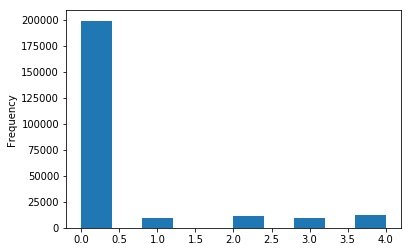

In [20]:
discretised_int['vaso_input'].plot.hist()

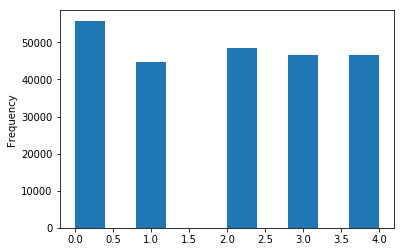

In [21]:
discretised_int['iv_input'].plot.hist()

In [22]:
disc_inp_data = copy.deepcopy(orig_data)

In [23]:
disc_inp_data['vaso_input'] = discretised_int['vaso_input']
disc_inp_data['iv_input'] = discretised_int['iv_input']

In [24]:
disc_inp_data.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,mortality_90d,Weight_kg,...,SIRS,median_dose_vaso,max_dose_vaso,input_total_tev,input_4hourly_tev,output_total,output_4hourly,cumulated_balance_tev,vaso_input,iv_input
0,1,3,7245052800,0,17639.826435,0.0,0,0,1,77.5,...,4,0.0,0.0,3500.0,2100.0,230.0,230.0,3270.0,0.0,4.0
1,2,3,7245067200,0,17639.826435,0.0,0,0,1,77.5,...,3,0.0,0.0,5499.0,1999.0,697.0,467.0,4802.0,0.0,4.0
2,3,3,7245081600,0,17639.826435,0.0,0,0,1,77.5,...,3,0.0,0.0,5604.0,105.0,2302.0,1605.0,3302.0,0.0,2.0
3,4,3,7245096000,0,17639.826435,0.0,0,0,1,77.5,...,3,0.0,0.0,5664.0,60.0,2922.0,620.0,2742.0,0.0,2.0
4,5,3,7245110400,0,17639.826435,0.0,0,0,1,77.5,...,3,0.0,0.0,5724.0,60.0,3352.0,430.0,2372.0,0.0,2.0


In [25]:
disc_inp_data['vaso_input'].value_counts()

0.0    199294
4.0     12453
2.0     11215
1.0      9892
3.0      9596
Name: vaso_input, dtype: int64

In [26]:
disc_inp_data['iv_input'].value_counts()

0.0    55819
2.0    48527
3.0    46658
4.0    46658
1.0    44788
Name: iv_input, dtype: int64

In [27]:
disc_inp_data.to_csv('../data/discretised_input_data.csv', index=False)